# Compter les cellules

Le traitement des images est beaucoup utilisé dans le domaine médical. Dans cette activité nous allons nous mettre dans la peau d'un chercheur en sciences de la vie et découvrir comment l'informatique et la programmation pourronnt nous être utile.

Le contexte est le suivant: nous voulons créer un milieu optimal pour multiplier des cellules souches. Pour savoir quel est ce milieu idéal, nous allons tester plusieurs milieux et suivre l'évolution de nos cellules et compter leur nombre au cours du temps. Comme nous ne souhaitons pas passer notre temps les yeux rivés sur notre microscope, nous récupérerons des images numériques de notre microscope, similaire à celle ci-dessous, et nous allons trouver un moyen d'automatiser le comptage de cellules.

![image_cells](images/cells.png)

Pour résoudre ce problème nous allons bien sur utiliser nos connaissances sur la manipulation d'images. Nous allons réutiliser les libraries précédentes et nous en rajouterons juste une, imageio, pour lire un fichier image standard. Tout le reste ne sera que de la logique.

In [2]:
import numpy as np # Pour manipuler des tableaux de nombres
import matplotlib.pyplot as plt # pour afficher des images
import imageio # pour lire notre photo

Commençons d'abord par vérifier que nous sommes bien en mesure de lire une de nos images et de la récupérer sous format numérique. 

<class 'imageio.core.util.Array'>
(326, 500, 4)


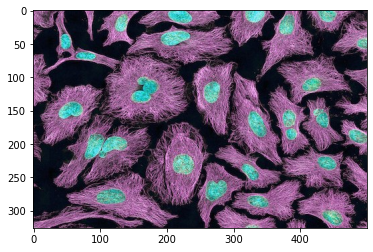

In [3]:
img_cells = imageio.imread('images/cells.png')
print(type(img_cells))
print(img_cells.shape)
plt.imshow(img_cells)
plt.show()

Ca joue. L'image a un type différent de numpy.ndarray, mais comme on peut le voir, c'est aussi un tableau avec des méthodes similaires à celles de numpy. Il y a par contre une différence majeure par rapport aux images utilisées jusqu'à présent. Mais ne nous alarmons pas... c'est simplement que le tableau a cette fois-ci 3 dimensions: la hauteur, la largeur et le **canal de couleur**. Notre image en fait est constituée de 4 images à 2 dimensions, correspondantes respectivement au canal rouge (`img_cells[:,:,0]`), au canal vert (`img_cells[:,:,1]`), au canal bleu (`img_cells[:,:,2]`) et au canal alpha (`img_cells[:,:,3]` correspondant à la transparence). Voyons ces 4 canaux séparement.

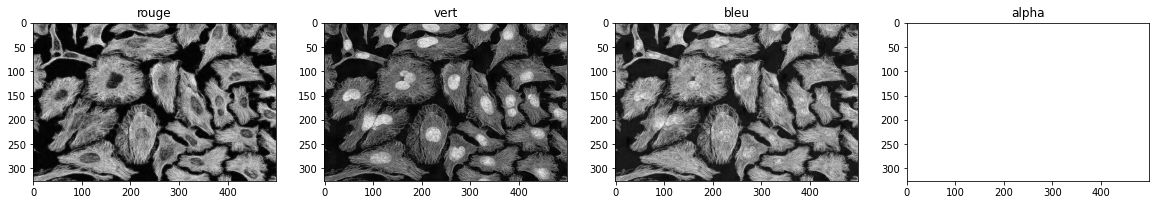

In [4]:
# Initialisation d'une figure contenant plusieurs graphiques:
# Pas la peine d'essayer de comprendre ce code dans tous ses détails,
# Lisez le et essayer de trouver les éléments importants
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.imshow(img_cells[:,:,0], cmap='gray',vmin = 0, vmax = 255)
ax1.set_title('rouge')
ax2.imshow(img_cells[:,:,1], cmap='gray',vmin = 0, vmax = 255)
ax2.set_title('vert')
ax3.imshow(img_cells[:,:,2], cmap='gray',vmin = 0, vmax = 255)
ax3.set_title('bleu')
ax4.imshow(img_cells[:,:,3], cmap='gray',vmin = 0, vmax = 255)
ax4.set_title('alpha')
plt.show()

## Stratégie: lire, segmenter, filtrer, grouper, compter

Pour compter automatiquement les cellules, voici l'approche que nous allons utiliser:

+ Nous allons segmenter l'image en deux pour isoler le fond des cellules, mais également isoler les cellules entre elles au mieux. Nous arriverons donc à une image avec deux valeurs possibles: des pixels à 255 s'ils sont considérés comme appartenants à une cellule, et les autres à 0.
+ Nous allons filtrer notre image, pour enelver le "bruit" de la segmentation.
+ Nous allons identifier les groupes de pixels correspondants à une même cellule.
+ Nous allons compter le nombre de cellules (le nombre de groupes de pixels à 1).

## Lire

Pour différencier les pixels du fond des pixels des cellules, le motif de l'image pourrait être utilisé, mais il y a plus simple. L'intensité lumineuse suffira et c'est ce que nous utiliserons. Comme le centre des cellules est le plus lumineux sur le canal vert, nous récupérerons l'image 2D corresondant à ce canal pour faire notre segmentation.

---
### Exercice 1
+ *En vous aidant du code d'affichage des canaux précédent, définir la variable `img_a_segmenter` pour qu'elle correponde au canal vert de `img_cells`*
+ *Ajouter une instruction pour que `img_a_segmenter` ne correponde qu'au premier 100x100 pixels de l'image de base. Cela permettra de travailler voir de plus près ce que nous faisons et de faciliter notre debuggage.*
+ *Afficher l'image correspondante à `img_a_segmenter`*

---

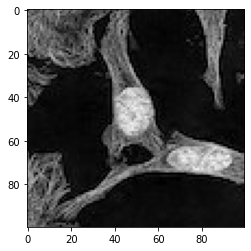

In [5]:
# Ex. 1
# ...

## Segmenter

Nous aimerions compter le nombre de cellule dans cette image. Pour cela on va d'abord séparer les pixels correspondants à des cellules du reste. Cela est possible puisque les cellules sont plus claires que le fond. On pourra donc séléctionner un seuil et exécuter un programme pour segmenter notre image en fonction de ce seuil: Si l'intensité du pixel est supérieur au seuil alors le pixel sera considéré comme appartenant à une cellule, sinon non. Nous stockeronns le résultat dans une nouvelle image appellée `image_segmentee`.

Le seuillage se fera en deux étapes: d'abord nous allons calculer et visualiser un histogramme qui permettra de savoir combien de fois chaque couleur apparait dans notre image. Cet histogramme nous permettra de choisir le seuil et de l'appliquer.

---
### Exercice 2
+ *Définir une fonction `get_histogramme(img)` qui prend une image en niveau de gris comme argument et qui retourne une liste de 256 valeurs, afin que la i_ème valeur de la liste retournée corresponde à combien de fois cette intensité est présente dans l'image img. Indice: on pourra initialiser un tableau de 256 valeurs à zéro avec l'instruction `np.zeros((256))`*
+ *Visualiser le résultat en utilisant la fonction `plt.bar` déjà mise à disposition.
+ *Définir une fonction `segmenter(img,seuil)` qui prend une image et un seuil pour argument et qui retourne une image de la même taille que img, avec pour intensité 0 où img < seuil et 255 où img >= seuil. Choisir un seuil et segmenter `img_a_segmenter`pour obtenir `img_segmentee`. 
---

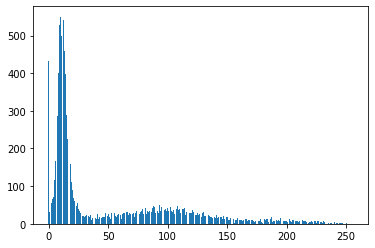

In [6]:
# Ex. 2
# def get_hitogramme

plt.bar(range(256),get_histogramme(img_a_segmenter))
plt.show()

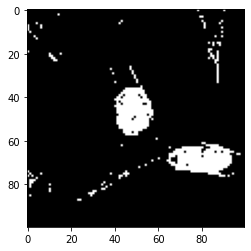

In [7]:
# Ex. 2
# def segmenter et seuil

img_segmentee = segmenter(img_a_segmenter,seuil)

plt.imshow(img_segmentee, cmap='gray',vmin = 0, vmax = 255)
plt.show()


## Filtrage

Comme vous pouvez probablement le voir, il n'est pas possible de trouver un seuil qui permette d'isoler proprement le noyau des cellules du fond. Or pour compter les cellules c'est nécessaire de le faire, car nous serons amenés à compter les groupes de pixels à 1 qui sont connectés. Pour résoudre le problème nous allons filtrer notre image de départ, comme si nous souhaitions le voir à travers de lunettes pleines de buée. En floutant notre image, les pixels de forte intensité qui sont isolés disparaitront.

De manière mathématique, le floutage n'est rien d'autre qu'une moyenne: je transforme l'intensité lumineuse de chaque pixel en la moyenne de l'insensité lumineuse de ce pixel et de ses voisins. 

---
### Exercice 3
+ *Définir une fonction `filtre(img)` qui prend une image en niveau de gris comme argument et qui une image floutée de `img`. Chaque pixel de l'image floutée est égal à la moyenne de l'intensité de ce pixel dans `img`et de ses 4 voisins directs.*
+ *Appliquer la fonction `filtre` à `image_a_segmanter` pour obtenir l'image `img_filtree`. Visualiser `img_filtree` ainsi que sa segmentation.
+ *Appliquer 5 fois le filtre sur `image_a_segmanter` et visualiser le résultat de la segmentation. 
---

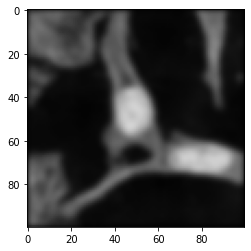

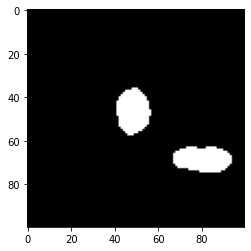

In [8]:
# filtrage
def readPixel(img,x,y):
    if x >=0 and y >= 0 and x <= img.shape[1]-1 and y <= img.shape[0]-1:
        return img[y,x]
    else:
        return 0

# Ex. 3
# def filtre
# img_filtree = ...
# img_segmentee = ...

plt.imshow(img_filtree, cmap='gray',vmin = 0, vmax = 255)
plt.imshow(img_segmentee, cmap='gray',vmin = 0, vmax = 255)
plt.show()

## Grouper

A présent nous devrions avoir deux noyaux qui sont mis en évidence dans notre image `img_segmentee`. Pour compter ces noyaux il va falloir être capable de faire reconnaitre à l'ordinateur que tous les pixels blancs du premier noyaux sont connectés entre eux, et qu'ils ne sont pas connectés à ceux du deuxième noyau.

---
### Exercice 4

+ *Définir une image `img_group` de la même taille que `img_segmentee` qui permettra de représentera le groupe auquel chaque pixel fait partie. Initialiser chaque élément de cette image à -1.*
+ *Parcourir l'image et assigner un groupe à différent à chaque pixel appartenant à une cellule. Ajouter des instructions pour que si deux pixels voisins d'une même ligne appartiennent à une cellule, alors le groupe de la cellule de droite devient celui de la cellule de gauche. Visualiser le résultat avec les instructions mises à votre disposition.* 
+ *Définir une fonction `change_image_where_to(img,val,val2)` qui permet de changer tous les pixels d'une image img ayant la valeur val et de leur donner la valeur val2.*
+ *Utiliser cette fonction pour que si deux pixels voisins d'une cellule appartiennent à une même colonne, alors le groupe du pixel en haut se propage au pixel du bas et à tous les pixels appartenant au même groupe que lui. Visualiser le résultat avec les instructions mises à votre disposition.*
---

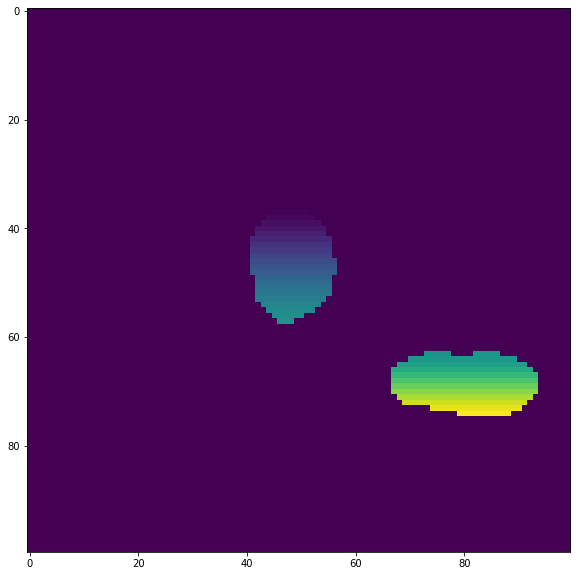

In [9]:
# Ex. 4
# img_group = ...
# init. img_group
# merge intra lignes

plt.figure(figsize = (10,10))# permet de régler la taille d'affichage de l'image
plt.imshow(img_group)
plt.show()



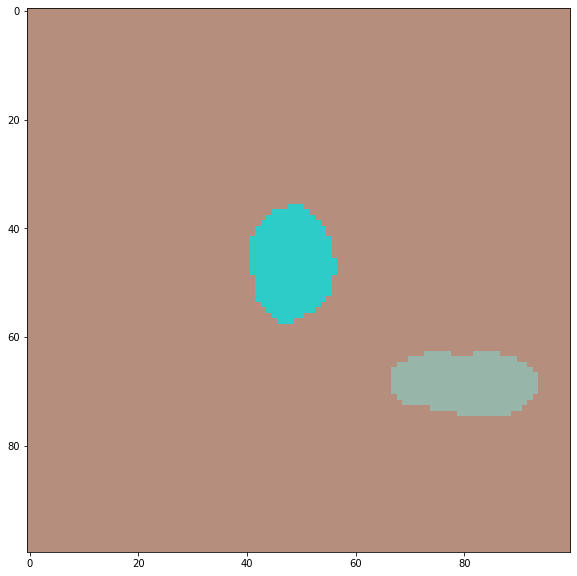

In [10]:
# Ex. 4
# def change_image_where_to
# merge inter lignes

# Visualisation de l'image finale
import matplotlib
cmap_rand = matplotlib.colors.ListedColormap(np.random.rand( 256,3))
plt.figure(figsize = (10,10))
plt.imshow(img_group, cmap_rand)
plt.show()

## Compter

Chaque pixel est identifié maintenant avec une valeur correspondant à un identifiant de groupe. Et chaque cellule correspond comme on le voit dans la visualisation précédente à un seul groupe. Pour compter le nombre de cellule, il ne nous reste plus qu'à identifier combien d'identifiants de groupe différents il y a.

---
### Exercice 5

+ *A l'aide de l'opérateur `in` qui permet de savoir si un élément est dans une liste ou non (essayer `1 in [0,1,2]`), définir une fonction `getSetFromImageGroupe(img_group)` qui prend une image représentant le groupe appartenant à chaque pixel et qui retourne une liste de groupe, sans doublon.*
+ *Afficher le nombre de cellule correspondant à la longueur de la liste retournée par la fonction `getSetFromImageGroupe(img_group)` après avoir enlevé la valeur -1. Pour cela vous pourrez utiliser la fonction remove (voir `list.remove?`).*
---

In [11]:
# Ex. 4
# def getSetFromImageGroupe
# list_group = ...
# enleve -1 de la liste

print("Il y a "+str(len(list_group))+ " cellules dans l'image")

Il y a 2 cellules dans l'image


## Elements connectés - version avancée

Alors que la solution utilisée précédemment est intuitive, elle n'est absolument pas efficace. En effet lorsque les groupes sont propagés de manière verticale, à chaque fois que nous trouvons deux pixels d'une cellule voisins, alors nous parcourons toute l'image pour remplacer des valeurs. Vous pouvez tester les limites de cette approche en applicant ce programme non plus à une section de l'image de 100x100 mais à l'image de départ et vous verrez le temps que cela prend.

Il y a beaucoup plus efficace. Mais qui dit plus efficace dit aussi souvent moins lisible. La stratégie pour faire plus rapidement sera la suivante :
+ On définit un état pour chacun de nos pixels comme ayant été visité ou non. Au début on considère qu'aucun pixel n'a été visité. On définira également un identifiant de groupe pour chaque pixel. Les pixels du premier groupe trouvé auront l'identifiant 1, le deuxième 2...
+ On commence à visier l'image en prenant le premier pixel à 255. On retient que ce pixel a été visité en changeant son état. On retient également que ce pixel appartient au groupe 1. On lance alors une fonction `propage_groupe` qui se propage à tous les voisins qui sont à 255 et qui n'ont pas encore été visités. La fonction met définit le groupe de chaque voisin visité, le marque comme visité, et se propage à tous leurs voisins qui sont à 255 et qui n'ont pas été visités. De cette manière, les groupes sont identifiés les uns après les autres.

---
### Exercice 6

Voici le programme correspondant à cet algorithme. Prenez un moment pour le lire et identifier l'algorithme derrière, et testez son efficacité.

---

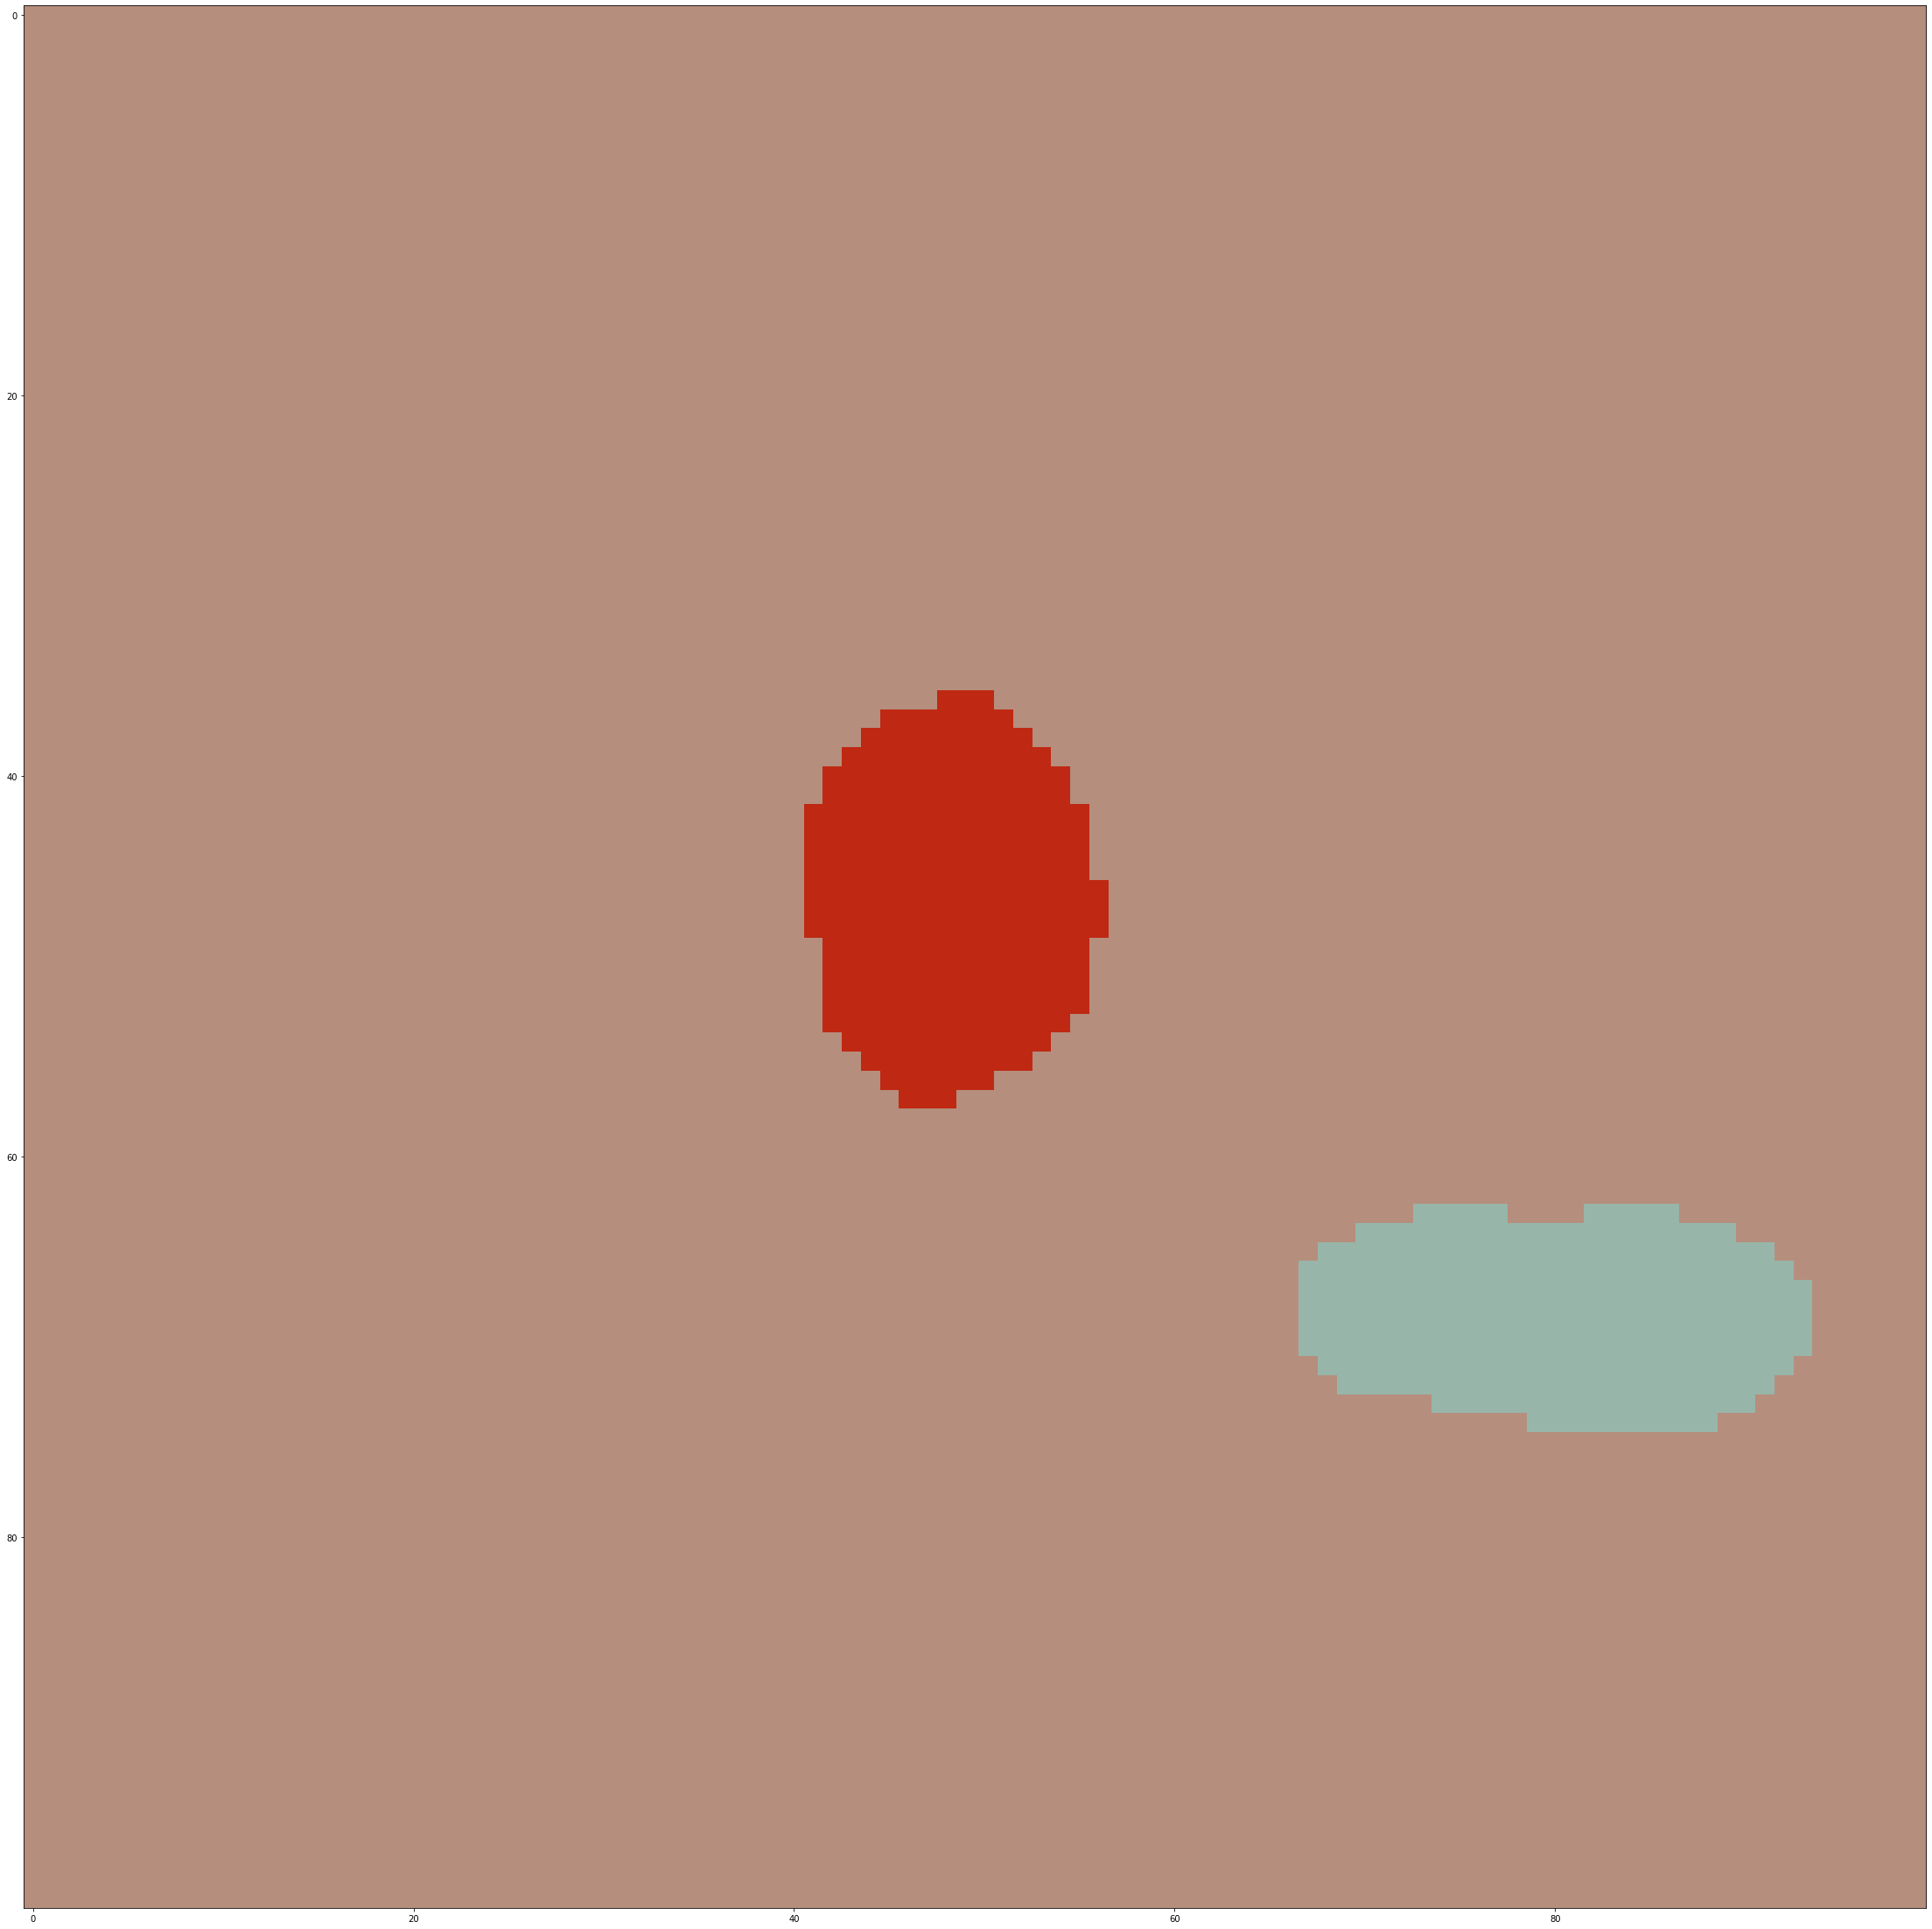

Il y a 2 cellules dans l'image


In [12]:
def propage_groupe_general(img,visit,group,x, y,groupe_c):
    visit[y,x] = 1 # marque pixel comme visité
    group[y,x] = groupe_c # retien sotn groupe

    if x-1 >= 0 and visit[y,x-1] == 0 and img[y,x-1] == 255:
        propage_groupe_general(img,visit,group,x-1,y,groupe_c)
    if x+1 < img.shape[1] and visit[y,x+1] == 0 and img[y,x+1] == 255:
        propage_groupe_general(img,visit,group,x+1,y,groupe_c)
    if y-1 >= 0 and visit[y-1,x] == 0 and img[y-1,x] == 255:
        propage_groupe_general(img,visit,group,x,y-1,groupe_c)
    if y+1 < img.shape[0] and visit[y+1,x] == 0 and img[y+1,x] == 255:
        propage_groupe_general(img,visit,group,x,y+1,groupe_c)

def connected_components(img_threshold):
    # défini deux variables par pixel: 
    # une pour savoir si un pixel a été visité par l'algorithme.
    # 0 pour "pas visité" et 1 pour visité
    visited_p = np.zeros(img_threshold.shape)
    # un autre pour savoir à quel groupe le pixel a été lié
    groupe_p = -np.ones(img_threshold.shape)

    # le premier pixel à 255 sera lié au groupe 1, ainsi que tous les pixels à 255
    # qui lui sont voisins, ainsi que tous les pixels à 255 qui sont voisins et voisins...
    # puisque le premier pixel et un voisin de son voisin, on utilise la variable vitite
    # pour ne pas faire un programme qui ne finit jamais. On propage ainsi le groupe seulement
    # sur les voisins qui n'ont pas été encore visités.
    groupe_courant = 1
    for y in range(img_threshold.shape[0]):
        for x in range(img_threshold.shape[1]):
            # si mon pixel est à 255 et qu'il n'a pas été visité
            if visited_p[y,x] == 0 and img_threshold[y,x] == 255:
                # alors on le lie au groupe groupe_courant ainsi que tous ses voisins de 
                # manière réccurrente.
                propage_groupe_general(img_threshold,visited_p,groupe_p,x,y,groupe_courant)
                # on liera le prochain pixel à 255 pas encore visité à un autre groupe
                groupe_courant += 1
    
    return groupe_courant, groupe_p 

# trouve les cellules
nb_groupes, image_groupe = connected_components(img_segmentee)
plt.figure(figsize = (40,40))
plt.imshow(image_groupe, cmap_rand)
plt.show()

# compte les cellules
list_group = getSetFromImageGroupe(image_groupe)
list_group.remove(-1)
print("Il y a "+str(len(list_group))+ " cellules dans l'image")


## Alternatives

Comment faudrait-il changer la denière étape de comptage pour que cela marche sans l'étape de filtrage ?